In [1]:
#%reset
import os
rundir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import os
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots_v2 as rpl
import rms_utils as rut
import matplotlib as mpl
import xarray as xr
import rms_utils_boot as rutb
from matplotlib.ticker import MultipleLocator
import glob
from scipy import stats
################settings
#mpl.style.reload_library()
#plt.style.use('rms_paper')
ystart=1955;ystop=2005;nyear=ystop+1-ystart
ystartb=1955;ystopb=1975

registering cmaps
registering cmaps


1a. Calculate GM annual mean TAS timeseries LE
#####################################################

In [2]:
# =====================================
# 1. Calculate and read data
# =====================================
files_arc={'historical':[],'hist-GHG':[],'hist-totalO3':[],'hist-stratO3':[],'hist-noCFC':[],'hist-noCFC-noO3':[],'hist-noaerosol':[],'hist-noCO2':[]} 

# =====================================
# 1a. Calculate 
# =====================================

srcdir_base='//space/hall4/sitestore/eccc/crd/ccrn/users/cmr203/ncconv/netcdfconv/'
srcdir_base2='//space/hall3/sitestore/eccc/crd/ccrn/users/ccc103/' 
datadir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/DATA/cfc_post'

do_calc=False

varnm='tas'

if do_calc:
    for forcing in sorted(files_arc.keys()):#: ['hist-noaerosol','hist-noCO2']:
        #print forcing
        os.system('mkdir -p {}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing)); 
        os.chdir('{}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing))
        os.system('/bin/rm *_'+forcing+'_*.nc')
        if forcing=='historical': os.system('ln -s '+ srcdir_base +'/final/CMIP6/CMIP/*/CanESM5/historical/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-GHG':   os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-GHG/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-totalO3': os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-totalO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-stratO3': os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-stratO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCFC': os.system('ln -s ' + srcdir_base2 +'/rms0056-0*/*/*/CMIP6/CMIP/*/*/hist-noCFC/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCFC-noO3': os.system('ln -s ' + srcdir_base2 +'/rms0058-0*/*/*/CMIP6/CMIP/*/*/hist-noCFC-noO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noaerosol': os.system('ln -s ' + srcdir_base2 +'/rms0066-0*/*/*/CMIP6/CMIP/*/*/hist-noaerosol/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCO2': os.system('ln -s ' + srcdir_base2 +'/rms0065-0*/*/*/CMIP6/CMIP/*/*/hist-noCO2/r*i1p*f1/Amon/tas/*/*/*.nc .')

            
        # concat
        ens_all = rut.cd_mkensemble('*_'+forcing+'_*',mip='cmip6')
        ens_all = cd.cat_exp_slices(ens_all)
        # annual means            
        my_cdo_str='cdo -yearmean -seldate,'+str(ystart)+'-01-01,'+str(ystop)+ '-12-31 {infile} {outfile}' 
        ens_all     =cd.my_operator(ens_all,      my_cdo_str, output_prefix='am_',delete=True)
        # global mean            
        my_cdo_str='cdo -fldmean  {infile} {outfile}' 
        ens_all_gm=cd.my_operator(ens_all, my_cdo_str, output_prefix='gm',delete=False)
        # arctic mean            
        my_cdo_str='cdo -fldmean  -sellonlatbox,0,360,60,90 {infile} {outfile}' 
        ens_all_arc=cd.my_operator(ens_all, my_cdo_str, output_prefix='arc',delete=False)   
        

# =====================================
# 1b. Read 
# =====================================          
files_gm={};rips={}
data_arc={};data_gm={};nens={};   

for forcing in files_arc.keys():
    #print forcing
    files_gm[forcing]=[]
    rips[forcing]=[]
    os.chdir('{}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing))
    #make file lists
    for i in range(1,51): 
        files_arc[forcing].extend(glob.glob('arcam*_'+forcing+'_*r'+str(i)+'i1p1f1*'))
        files_gm[forcing].extend(glob.glob('gmam*_'+forcing+'_*r'+str(i)+'i1p1f1*'))        
    for i in range(1,51): #for historical-p2, 40 members available, but only 25 used here
        files_arc[forcing].extend(glob.glob('arcam*_'+forcing+'_*r'+str(i)+'i1p2f1*'))
        files_gm[forcing].extend(glob.glob('gmam*_'+forcing+'_*r'+str(i)+'i1p2f1*'))               
    #print files_arc[forcing]
    #get rips
    nens[forcing]=len(files_arc[forcing])
    for i in range(nens[forcing]):
        rips[forcing].append(files_arc[forcing][i].split("_")[5])
        print forcing,rips[forcing][i]    
    #declare variables
    data_arc[forcing]=np.zeros((nens[forcing],nyear))*np.nan  
    data_gm[forcing]=np.zeros((nens[forcing],nyear))*np.nan  
    #read data
    for i,file in enumerate(files_arc[forcing]):
        df=xr.open_dataset(file)
        data_arc[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data-\
                       df.sel(time=slice(str(ystartb),str(ystopb))).mean(dim='time').tas.data).squeeze()         
    for i,file in enumerate(files_gm[forcing]):
        df=xr.open_dataset(file)
        data_gm[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data-\
                       df.sel(time=slice(str(ystartb),str(ystopb))).mean(dim='time').tas.data).squeeze()         
os.chdir(rundir)




hist-noCFC-noO3 r1i1p2f1
hist-noCFC-noO3 r2i1p2f1
hist-noCFC-noO3 r3i1p2f1
hist-noCFC-noO3 r4i1p2f1
hist-noCFC-noO3 r5i1p2f1
hist-noCFC-noO3 r6i1p2f1
hist-noCFC-noO3 r7i1p2f1
hist-noCFC-noO3 r8i1p2f1
hist-noCFC-noO3 r9i1p2f1
hist-noCFC-noO3 r10i1p2f1
hist-noCFC-noO3 r11i1p2f1
hist-noCFC-noO3 r12i1p2f1
hist-noCFC-noO3 r13i1p2f1
hist-noCFC-noO3 r14i1p2f1
hist-noCFC-noO3 r15i1p2f1
hist-noCFC-noO3 r16i1p2f1
hist-noCFC-noO3 r17i1p2f1
hist-noCFC-noO3 r18i1p2f1
hist-noCFC-noO3 r19i1p2f1
hist-noCFC-noO3 r20i1p2f1
hist-noCO2 r1i1p2f1
hist-noCO2 r2i1p2f1
hist-noCO2 r3i1p2f1
hist-noCO2 r4i1p2f1
hist-noCO2 r5i1p2f1
hist-noCO2 r6i1p2f1
hist-noCO2 r7i1p2f1
hist-noCO2 r8i1p2f1
hist-noCO2 r9i1p2f1
hist-noCO2 r10i1p2f1
hist-noCO2 r11i1p2f1
hist-noCO2 r12i1p2f1
hist-noCO2 r13i1p2f1
hist-noCO2 r14i1p2f1
hist-noCO2 r15i1p2f1
hist-noCO2 r16i1p2f1
hist-noCO2 r17i1p2f1
hist-noCO2 r18i1p2f1
hist-noCO2 r19i1p2f1
hist-noCO2 r20i1p2f1
hist-GHG r1i1p1f1
hist-GHG r2i1p1f1
hist-GHG r3i1p1f1
hist-GHG r4i1p1f1
hist-G

In [3]:
#==========================================================
#2. Calc deltas 
#==========================================================

years=np.arange(ystart,ystop+1)

###using linear trend method
delttrend_arc={};delttrend_gm={}
for forcing in sorted(files_arc.keys()):
    delttrend_arc[forcing]=np.zeros((nens[forcing]))*np.nan
    delttrend_gm[forcing]=np.zeros((nens[forcing]))*np.nan
    
    for i in range(nens[forcing]):
        delttrend_arc[forcing][i]=np.polyfit(years,data_arc[forcing][i,:],1)[0]*(ystop-ystart)
        delttrend_gm[forcing][i]=np.polyfit(years,data_gm[forcing][i,:],1)[0]*(ystop-ystart)
        
###simple difference between first and last decades
deltdecade_arc={};deltdecade_gm={}
for forcing in sorted(files_arc.keys()):
    deltdecade_arc[forcing]=np.zeros((nens[forcing]))*np.nan
    deltdecade_gm[forcing]=np.zeros((nens[forcing]))*np.nan
    
    for i in range(nens[forcing]):
        deltdecade_gm[forcing][i]=np.mean(data_gm[forcing][i,-10::],axis=0)-np.mean(data_gm[forcing][i,0:10],axis=0)
        deltdecade_arc[forcing][i]=np.mean(data_arc[forcing][i,-10::],axis=0)-np.mean(data_arc[forcing][i,0:10],axis=0)
        
 

        
        

[0.48638    0.40401917 0.2436554  0.3960083  0.50540161 0.1765564
 0.27216492 0.03654785 0.40235901 0.32912292 0.49197388 0.52220154
 0.4322876  0.12326965 0.3523468  0.28125305 0.24131775 0.33579712
 0.22784424 0.48396301]
[ 0.59336548  0.51785583  0.68403625  0.4646637   1.35200195  1.19607544
 -0.1465332  -0.18922119  1.00585022  0.82063599  0.80792542  1.7004303
  1.22378845  0.25524902  0.74673767  1.11274109  0.66263733  0.77443542
  0.75665283  1.53600159]


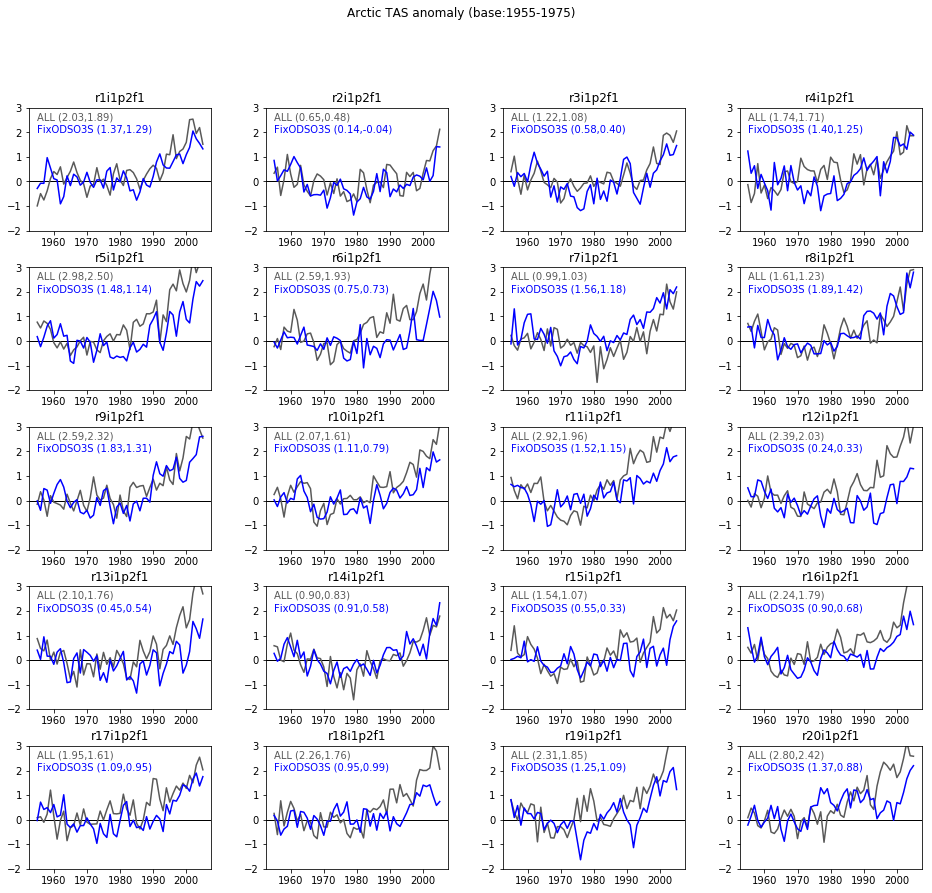

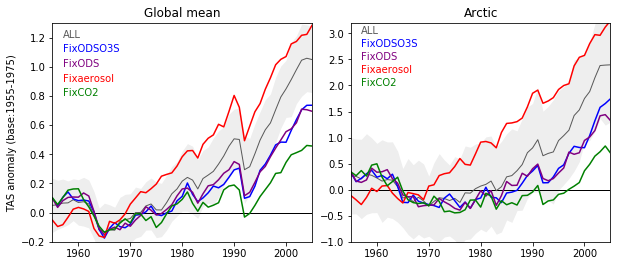

In [4]:
#==========================================================
#3. Plots  
#==========================================================
os.system('mkdir -p PLOTS')

labels={'historical':'ALL',
        'hist-GHG':'GHG',
        'hist-totalO3':'O3',
        'hist-stratO3':'O3S',
        'hist-noCFC':'FixODS',
        'hist-noCFC-noO3':'FixODSO3S',
        'hist-noaerosol':'Fixaerosol',
        'hist-noCO2':'FixCO2'}

colors={'historical':[0.35,0.35,0.35],
        'hist-GHG':'red',
        'hist-totalO3':'orange',
        'hist-stratO3':'brown',
        'hist-noCFC':'purple',
        'hist-noCFC-noO3':'blue',
        'hist-noaerosol':'red',
        'hist-noCO2':'green'        
       }


#==========================================================
#3a. Timeseries individual members 
#==========================================================
############### Setup fig
fig1, axs = plt.subplots(5,4, figsize=(16,14)); 
fig1.subplots_adjust(hspace=0.3,wspace=0.3)

for i in range(20):
    ax=axs.flat[i]
    ### zero line
    ax.axhline(y=0,color="black",linewidth=1)
    ax.set_ylim([-2,3])
    #ax.set_ylabel('TAS anomaly (base:1955-1975)')
    ax.plot(years,data_arc['historical'][i+25,:],color=colors['historical'])
    ax.plot(years,data_arc['hist-noCFC-noO3'][i,:],color=colors['hist-noCFC-noO3'])

    ax.text(1955,2.5,'{} ({},{})'.format(labels['historical'],"%4.2f"%(delttrend_arc['historical'][i+25]),"%4.2f"%(deltdecade_arc['historical'][i+25])),color=colors['historical']) 
    ax.text(1955,2,'{} ({},{})'.format(labels['hist-noCFC-noO3'],"%4.2f"%(delttrend_arc['hist-noCFC-noO3'][i]),"%4.2f"%(deltdecade_arc['hist-noCFC-noO3'][i])),color=colors['hist-noCFC-noO3']) 
    #rpl.add_title(ax,rips['historical'][i+25])
    rpl.add_title(ax,rips['hist-noCFC-noO3'][i])

##save
fig1.suptitle('Arctic TAS anomaly (base:1955-1975)')
rpl.mysavefig(fig1,'PLOTS/tas_past_CanESM5_timeseries_ensemble_members.png')

#print rips['historical'][25:45]
#print rips['hist-noCFC-noO3']

#print deltdecade_arc['historical'][25:45]
#print deltdecade_arc['hist-noCFC-noO3']
print deltdecade_gm['historical'][25:45]-deltdecade_gm['hist-noCFC-noO3']
print deltdecade_arc['historical'][25:45]-deltdecade_arc['hist-noCFC-noO3']

#==========================================================
#3b. Timeseries ensemble means
#==========================================================
############### Setup fig
fig1, axs = plt.subplots(1,2, figsize=(10,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)

############### global mean
ax=axs.flat[0]

ax.set_xlim([1955, 2005]) 
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylim([-0.2, 1.3]) 
ax.set_ylabel('TAS anomaly (base:1955-1975)')

##all forcing
kwargs={'linewidth': 1, 'color': colors['historical']}
ax.plot(years,np.mean(data_gm['historical'],axis=0),**kwargs)
kwargs['alpha']=0.1; kwargs['linewidth']=0
ax.fill_between(years,np.mean(data_gm['historical'],axis=0)-1.67*np.std(data_gm['historical'],axis=0),
                      np.mean(data_gm['historical'],axis=0)+1.67*np.std(data_gm['historical'],axis=0),**kwargs)
ax.text(1957,1.2,labels['historical'],color=colors['historical'])

##fixed
for i,forcing in enumerate(['hist-noCFC-noO3','hist-noCFC','hist-noaerosol','hist-noCO2']):
    ax.plot(years,np.mean(data_gm[forcing],axis=0),color=colors[forcing])
    ax.text(1957,1.1-i*0.1,labels[forcing],color=colors[forcing])

##title and legend
rpl.add_title(ax,'Global mean')


############### Arctic
ax=axs.flat[1]

ax.set_xlim([1955, 2005]) 
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylim([-1, 3.2]) 
#ax.set_ylabel('TAS anomaly (base:1955-1975)')

ax.axhline(y=0,color="black",linewidth=1)

##all forcing
kwargs={'linewidth': 1, 'color': colors['historical']}
ax.plot(years,np.mean(data_arc['historical'],axis=0),**kwargs)
kwargs['alpha']=0.1; kwargs['linewidth']=0
ax.fill_between(years,np.mean(data_arc['historical'],axis=0)-1.67*np.std(data_arc['historical'],axis=0),
                      np.mean(data_arc['historical'],axis=0)+1.67*np.std(data_arc['historical'],axis=0),**kwargs)
ax.text(1957,3.0,labels['historical'],color=colors['historical'])
##fixed
for i,forcing in enumerate(['hist-noCFC-noO3','hist-noCFC','hist-noaerosol','hist-noCO2']):
    ax.plot(years,np.mean(data_arc[forcing],axis=0),color=colors[forcing])
    ax.text(1957,2.75-i*0.25,labels[forcing],color=colors[forcing])

rpl.add_title(ax,'Arctic')

rpl.mysavefig(fig1,'PLOTS/tas_past_CanESM5_timeseries.png')


0.82
0.34
0.35
0.56
-0.31
1.60
0.79
0.93
1.54
-1.10
1.93
2.13
2.61
2.70
3.66
1.01
0.41
0.40
0.68
-0.38
1.98
0.93
1.04
1.82
-1.46
1.94
1.99
2.50
2.59
3.84


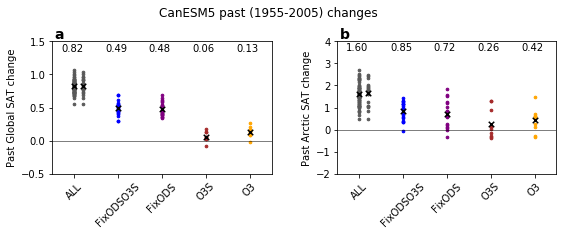

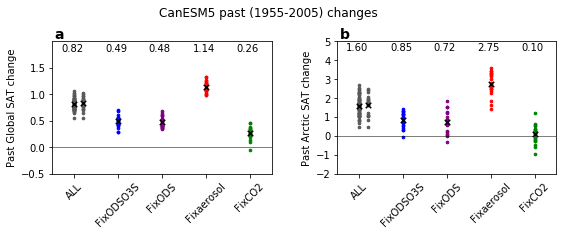

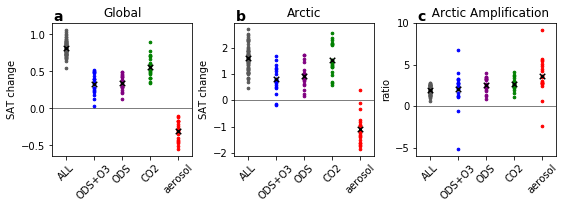

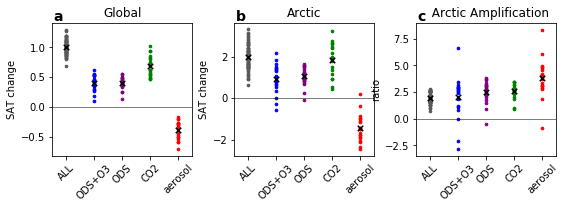

In [5]:
#==========================================================
#3c. Barplot trends based on trend method 
#==========================================================

def plot_scatter(ax,col,nens,dtas,color):
    ax.scatter(np.ones(nens)*col,dtas,7,color)
    ax.scatter(col,np.mean(dtas),30,'black','x')

    
def plot_barplot(ax,ax_label,region,ymin,ymax,forcings,data):    
    ### Title
    rpl.add_title(ax,'',ax_label)
    ### x-axis
    plot_labels=[]
    nbars=len(forcings)
    for i in range(nbars):
        plot_labels.append(labels[forcings[i]])
    ax.set_xlim([0.5, nbars+0.5]) 
    ax.set_xticks(np.arange(1,nbars+1))
    ax.set_xticklabels(plot_labels,rotation=45)
    ### y-axis
    ax.set_ylim([ymin, ymax]) 
    if region=='Global': ax.set_yticks(np.arange(np.floor(ymin*2)/2,np.ceil(ymax+1*2)/2,0.5))
    if region=='Arctic': ax.set_yticks(np.arange(np.floor(ymin),np.ceil(ymax+1),1))
    
    ax.set_ylabel('Past '+region + ' SAT change')
    ax.axhline(y=0,color="black",linewidth=0.5)

    ### model data
    for i,forcing in enumerate(forcings):
        plot_scatter(ax,i+1,nens[forcing],data[forcing],colors[forcing])
        ax.text(i+1-0.3,ymax*0.9,"%4.2f"%(np.mean(data[forcing])))
    plot_scatter(ax,1.2,20,data['historical'][25:44+1],colors['historical']) ### historical_r[1-20]i1p2f1    
    ### obs
    #ax.scatter(1,0.7,50,'green',zorder=0)

plot_trend_method=False
if plot_trend_method:
    #===========ODS=============================================
    fig1, axs = plt.subplots(1,2, figsize=(8,8)); 
    fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)

    plot_forcings=['historical','hist-noCFC-noO3','hist-noCFC','hist-stratO3','hist-totalO3']
    plot_barplot(axs[0],'a','Global',-0.2,1.5,plot_forcings,delttrend_gm)    
    plot_barplot(axs[1],'b','Arctic',-2,4,plot_forcings,delttrend_arc)    
    ##save
    fig1.suptitle('CanESM5 past ({}-{}) changes (trend method)'.format(ystart,ystop),y=0.94)
    rpl.mysavefig(fig1,'PLOTS/delttrend_past_CanESM5_ODS.png')
    #===========ALLFIXED=============================================
    fig1, axs = plt.subplots(1,2, figsize=(8,8)); 
    fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)

    plot_forcings=['historical','hist-noCFC-noO3','hist-noCFC','hist-noaerosol','hist-noCO2']
    plot_barplot(axs[0],'a','Global',-0.2,2,plot_forcings,delttrend_gm)    
    plot_barplot(axs[1],'b','Arctic',-2,5,plot_forcings,delttrend_arc)    

    ##save
    fig1.suptitle('CanESM5 past ({}-{}) changes (trend method)'.format(ystart,ystop),y=0.94)
    rpl.mysavefig(fig1,'PLOTS/delttrend_past_CanESM5_ALLFIXED.png')

#==========================================================
#3d. Barplot trends based on decade method 
#==========================================================

#===========ODS=============================================

fig1, axs = plt.subplots(1,2, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)

plot_forcings=['historical','hist-noCFC-noO3','hist-noCFC','hist-stratO3','hist-totalO3']
plot_barplot(axs[0],'a','Global',-0.2,1.5,plot_forcings,deltdecade_gm)    
plot_barplot(axs[1],'b','Arctic',-2,4,plot_forcings,deltdecade_arc)    

##save
fig1.suptitle('CanESM5 past ({}-{}) changes'.format(ystart,ystop),y=0.94)
rpl.mysavefig(fig1,'PLOTS/deltdecade_past_CanESM5_ODS.png')

#===========ALLFIXED=============================================
fig1, axs = plt.subplots(1,2, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)

plot_forcings=['historical','hist-noCFC-noO3','hist-noCFC','hist-noaerosol','hist-noCO2']
plot_barplot(axs[0],'a','Global',-0.2,2,plot_forcings,deltdecade_gm)    
plot_barplot(axs[1],'b','Arctic',-2,5,plot_forcings,deltdecade_arc)    

##save
fig1.suptitle('CanESM5 past ({}-{}) changes'.format(ystart,ystop),y=0.94)
rpl.mysavefig(fig1,'PLOTS/deltdecade_past_CanESM5_ALLFIXED.png')

#==========================================================
#3e. Barplot trends based on decade method [ALL MIN FIXED VERSION,including Arctic amplification]
#==========================================================
fig1, axs = plt.subplots(1,3, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)


#Global
ax=axs[0]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Global','a')

x=deltdecade_gm['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCFC-noO3']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCFC']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCO2']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noaerosol']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])

ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)

#Arctic

ax=axs[1]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Arctic','b')

x=deltdecade_arc['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCFC-noO3']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCFC']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCO2']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noaerosol']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])

ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)

#Arctic amplification

ax=axs[2]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
#ax.set_ylim([0, 5]) 
ax.set_ylabel('ratio')
rpl.add_title(ax,'  Arctic Amplification','c')

x=deltdecade_arc['historical']/deltdecade_gm['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=(deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCFC-noO3'])/\
  (deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCFC-noO3'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=(deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCFC'])/\
  (deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCFC'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=(deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noCO2'])/\
  (deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noCO2'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=(deltdecade_arc['historical'][25:44+1]-deltdecade_arc['hist-noaerosol'])/\
  (deltdecade_gm['historical'][25:44+1]-deltdecade_gm['hist-noaerosol'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])


ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)


rpl.mysavefig(fig1,'PLOTS/deltdecade_past_CanESM5_ALL_MIN_FIXED.png')

#==========================================================
#3f. Barplot trends based on trend method [ALL MIN FIXED VERSION,including Arctic amplification]
#==========================================================
fig1, axs = plt.subplots(1,3, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)


#Global
ax=axs[0]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Global','a')

x=delttrend_gm['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCFC-noO3']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCFC']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCO2']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noaerosol']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])

ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)

#Arctic

ax=axs[1]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Arctic','b')

x=delttrend_arc['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCFC-noO3']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCFC']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCO2']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noaerosol']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])

ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)

#Arctic amplification

ax=axs[2]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
#ax.set_ylim([0, 5]) 
ax.set_ylabel('ratio')
rpl.add_title(ax,'  Arctic Amplification','c')

x=delttrend_arc['historical']/delttrend_gm['historical']; print "%4.2f"%(np.mean(x))
plot_scatter(ax,1,nens['historical'],x,colors['historical'])

x=(delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCFC-noO3'])/\
  (delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCFC-noO3'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,2,20,x,colors['hist-noCFC-noO3'])

x=(delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCFC'])/\
  (delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCFC'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,3,20,x,colors['hist-noCFC'])

x=(delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noCO2'])/\
  (delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noCO2'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,4,20,x,colors['hist-noCO2'])

x=(delttrend_arc['historical'][25:44+1]-delttrend_arc['hist-noaerosol'])/\
  (delttrend_gm['historical'][25:44+1]-delttrend_gm['hist-noaerosol'])   
print "%4.2f"%(np.mean(x))
plot_scatter(ax,5,20,x,colors['hist-noaerosol'])


ax.set_xticklabels(['ALL','ODS+O3','ODS','CO2','aerosol'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)


rpl.mysavefig(fig1,'PLOTS/delttrend_past_CanESM5_ALL_MIN_FIXED.png')


In [30]:
#==========================================================
#4. Print out numbers 
#==========================================================

#==========================================================
#4a. % decrease in fixed versus all forcing 
#==========================================================

print 'Global warming % decrease due to ODS'
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCFC-noO3']))/np.mean(deltdecade_gm['historical'])*100)
print 'Global warming % decrease due to CO2'
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCO2']))/np.mean(deltdecade_gm['historical'])*100)
print 'Global warming ODS relative to CO2 impact'
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCFC-noO3']))/(np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCO2']))*100)
print ''
print 'Arctic warming % decrease due to ODS'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCFC-noO3']))/np.mean(deltdecade_arc['historical'])*100)
print 'Arctic warming % decrease due to CO2'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCO2']))/np.mean(deltdecade_arc['historical'])*100)
print 'Arctic warming ODS relative to CO2 impact'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCFC-noO3']))/(np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCO2']))*100)

#==========================================================
#4b. Statistical significance of difference 
#==========================================================
print (stats.ttest_ind(deltdecade_arc['historical'],deltdecade_arc['hist-noCFC-noO3'])[1])
print (stats.ttest_ind(deltdecade_arc['hist-noCFC'],deltdecade_arc['hist-noCFC-noO3'])[1])

#==========================================================
#4c. data to outfile for Lorenzo postdoc 
#==========================================================

text_file = open("DATA/CanESM5_deltdecade.txt", "w")

for forcing in ['historical','hist-noCO2','hist-noCFC-noO3']:
    print forcing
    
    text_file.write(labels[forcing]+ '\n')
    text_file.write("global  arctic " + '\n')

    if forcing=='historical':
        ioffset=25;
    else:
        ioffset=0        
    
    for i in range(20):
        text_file.write("%6.4f"%(deltdecade_gm[forcing][i+ioffset]) + '   '
                       +"%6.4f"%(deltdecade_arc[forcing][i+ioffset]) + '  '+ '\n')
                                 
text_file.close()            


text_file = open("DATA/CanESM5_delttrend.txt", "w")

for forcing in ['historical','hist-noCO2','hist-noCFC-noO3']:
    print forcing
    
    text_file.write(labels[forcing]+ '\n')
    text_file.write("global  arctic " + '\n')

    if forcing=='historical':
        ioffset=25;
    else:
        ioffset=0        
    
    for i in range(20):
        text_file.write("%6.4f"%(delttrend_gm[forcing][i+ioffset]) + '   '
                       +"%6.4f"%(delttrend_arc[forcing][i+ioffset]) + '  '+ '\n')
                                 
text_file.close()            







Global warming % decrease due to ODS
39.94
Global warming % decrease due to CO2
67.62
Global warming ODS relative to CO2 impact
59.07

Arctic warming % decrease due to ODS
46.74
Arctic warming % decrease due to CO2
93.78
Arctic warming ODS relative to CO2 impact
49.84
1.8556603607443115e-08
0.39783054511992477
historical
hist-noCO2
hist-noCFC-noO3
historical
hist-noCO2
hist-noCFC-noO3


1.8556603607443115e-08
0.39783054511992477


1.8417506933427807
2.1173174330767206
1.979541945356939


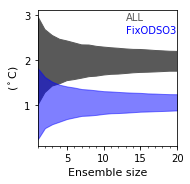

In [11]:
#==========================================================
#6. bootstrapping all minus fixODSO3 
#==========================================================

s1=delttrend_arc['historical']
s2=delttrend_arc['hist-noCFC-noO3']

nens=65;nboot=10000
s1_boot_mean=np.zeros((nens))
s1_boot_min=np.zeros((nens))
s1_boot_max=np.zeros((nens))

for nsamp in range (nens):
    s1_boot=np.zeros((nboot))
    
    for iboot in range(nboot):
        resample_i = np.floor(np.random.rand(nsamp+1)*nens).astype(int)
        s1_boot[iboot]=np.mean(s1[resample_i]) 
        
    s1_boot_mean[nsamp],s1_boot_min[nsamp],s1_boot_max[nsamp],a=rutb.calc_boot_stats(s1_boot,sides=1)

    
nens=20
s2_boot_mean=np.zeros((nens))
s2_boot_min=np.zeros((nens))
s2_boot_max=np.zeros((nens))

for nsamp in range (nens):
    s2_boot=np.zeros((nboot))
    
    for iboot in range(nboot):
        resample_i = np.floor(np.random.rand(nsamp+1)*nens).astype(int)
        s2_boot[iboot]=np.mean(s2[resample_i]) 
        
    s2_boot_mean[nsamp],s2_boot_min[nsamp],s2_boot_max[nsamp],a=rutb.calc_boot_stats(s2_boot,sides=1)
    
################PLOT

ncol=1; nrow=1;fig7, axs = plt.subplots(nrow,ncol, figsize=(ncol*2.5,nrow*2.5));     


####Ensembles
ax=axs
ax.set_xlim([1, 20])
ax.set_xticks(np.arange(5,20,5))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1)) 
ax.set_xlabel('Ensemble size',fontsize=11)

#ax.plot(np.arange(1,66),s1_boot_mean,color=[0.35,0.35,0.35],linewidth=0.5)
#ax.plot(np.arange(1,66),s1_boot_min,color=[0.35,0.35,0.35],linewidth=0.5)
#ax.plot(np.arange(1,66),s1_boot_max,color=[0.35,0.35,0.35],linewidth=0.5)
ax.fill_between(np.arange(1,66),s1_boot_min,s1_boot_max,color=colors['historical'])
ax.fill_between(np.arange(1,21),s2_boot_min,s2_boot_max,color=colors['hist-noCFC-noO3'],alpha=0.5)

ax.text(13,2.9,'ALL',color=colors['historical'])
ax.text(13,2.6,'FixODSO3',color=colors['hist-noCFC-noO3'])
ax.set_ylabel('($^\circ$C)',fontsize=11)

rpl.mysavefig(fig7,'PLOTS/deltdecade_tas_function_of_ensemble_size.png')    

print s1_boot_min[49]
print s1_boot_max[49]
print s1_boot_mean[49]